# Planet transit simulations

In this notebook we create synthetic spectra:
1. Possessing two photosphere components with filling factor $f_{spot}$.
2. Possessing two photosphere components with filling factor $f_{spot}$, and exoplanet filling factor $D$ on the ambient photosphere.

With filling factor geometries following Rackham et al. 2017 and 2018.

In [1]:
# %load ~/Desktop/defaults.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import astropy.units as u
import seaborn as sns
sns.set_context('talk')
import h5py

### Get exoplanet transit spectrum

We can use Caroline Morley's models from [her website](https://www.carolinemorley.com/models).  We want:

"MORLEY ET AL. 2015: SUB-NEPTUNE MODELS INCLUDING THE EFFECTS OF CLOUDS AND HAZES"
> Models of GJ 1214b “analogs” from Morley et al. 2015, including cloudy, hazy, and cloud-free models. These include thermal emission, transmission, and albedo spectra. Other similar models available upon request. 

Let's read in the transmission spectra data.

In [3]:
#! cat ../data/Morley2015_models/published_models/_README.txt

In [4]:
! ls ../data/Morley2015_models/published_models/emission_spectra/cloud-free/

gj1214-1000x-0.3x-nc.spec gj1214-150x-1x-nc.spec    gj1214-300x-0.3x-nc.spec
gj1214-1000x-10x-nc.spec  gj1214-150x-3x-nc.spec    gj1214-300x-10x-nc.spec
gj1214-1000x-1x-nc.spec   gj1214-200x-0.3x-nc.spec  gj1214-300x-1x-nc.spec
gj1214-1000x-3x-nc.spec   gj1214-200x-10x-nc.spec   gj1214-300x-3x-nc.spec
gj1214-100x-0.3x-nc.spec  gj1214-200x-1x-nc.spec    gj1214-50x-0.3x-nc.spec
gj1214-100x-10x-nc.spec   gj1214-200x-3x-nc.spec    gj1214-50x-10x-nc.spec
gj1214-100x-1x-nc.spec    gj1214-250x-0.3x-nc.spec  gj1214-50x-1x-nc.spec
gj1214-100x-3x-nc.spec    gj1214-250x-10x-nc.spec   gj1214-50x-30x-nc.spec
gj1214-150x-0.3x-nc.spec  gj1214-250x-1x-nc.spec    gj1214-50x-3x-nc.spec
gj1214-150x-10x-nc.spec   gj1214-250x-3x-nc.spec


The file names describe the contents.
> cloud-free:
gj1214-METALLICITY-INCIDENTFLUX-nc.[[append]]
e.g. gj1214-50x-0.3x-nc.spec is 50x solar, 0.3x GJ 1214b's
	incident flux, and cloud-free, emission spectrum. 

In [5]:
! head ../data/Morley2015_models/published_models/transmission_spectra/cloud-free/gj1214-100x-1x-nc.out

wavelength (microns) 	 radius (km) 
      30.0000   17201.5230     
      29.9911   17065.3259     
      29.9822   17110.6001     
      29.9733   17276.7692     
      29.9644   17066.4351     
      29.9555   17084.3500     
      29.9466   17123.8913     
      29.9377   17213.5251     
      29.9289   17356.1280     


In [6]:
fn = '../data/Morley2015_models/published_models/transmission_spectra/cloud-free/gj1214-100x-1x-nc.out'
df_raw = pd.read_csv(fn, delim_whitespace=True, names=['wl_um', 'radius_km'], skiprows=1)

In [7]:
df_raw.head()

,wl_um,radius_km
0,30.0000,17201.5230
1,29.9911,17065.3259
2,29.9822,17110.6001
3,29.9733,17276.7692
4,29.9644,17066.4351


In [8]:
nir_bounds = (df_raw.wl_um > 1.15) & (df_raw.wl_um < 2.45)
df = df_raw#[nir_bounds].copy()
df = df.reset_index(drop=True)

In [9]:
R_scale = u.km/u.earthRad

In [10]:
df['radius_earth'] = df.radius_km * R_scale.to(u.dimensionless_unscaled)

In [11]:
R_GJ1215 = 0.2064 #R_sun

The peak transit depth is:

transit_depth = $\frac{R^2_{\mathrm{planet}}}{R^2_\star} $

In [12]:
df['radius_Rstar'] = df.radius_km*(u.km/(R_GJ1215*u.solRad)).to(u.dimensionless_unscaled)

In [13]:
df['transit_depth'] = df.radius_Rstar**2

In [14]:
df.head()

,wl_um,radius_km,radius_earth,radius_Rstar,transit_depth
0,30.0000,17201.5230,2.696967,0.119794,0.014351
1,29.9911,17065.3259,2.675613,0.118846,0.014124
2,29.9822,17110.6001,2.682711,0.119161,0.014199
3,29.9733,17276.7692,2.708764,0.120318,0.014476
4,29.9644,17066.4351,2.675787,0.118853,0.014126


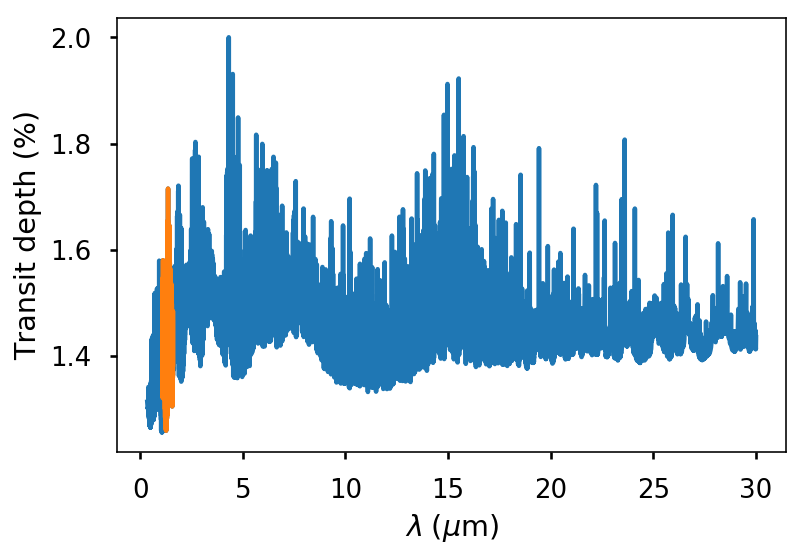

In [15]:
#plt.figure(figsize=(20,10))
plt.plot(df.wl_um, df.transit_depth*100.0)
ji = (df.wl_um >1.1) & (df.wl_um <1.6 )
plt.plot(df.wl_um[ji], df.transit_depth[ji]*100.0)
plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.ylabel('Transit depth (%)')
#plt.title('Morley et al. 2015 Models of GJ1214b: \n 100x metallicity, cloud-free', fontsize=12)
plt.savefig('../figures/GJ1214b_wl_depth.pdf', bbox_inches='tight')

In [16]:
np.sqrt((((df.transit_depth[ji]*100.0) - (df.transit_depth[ji]*100.0).median())**2).sum())

2.4904957269017061

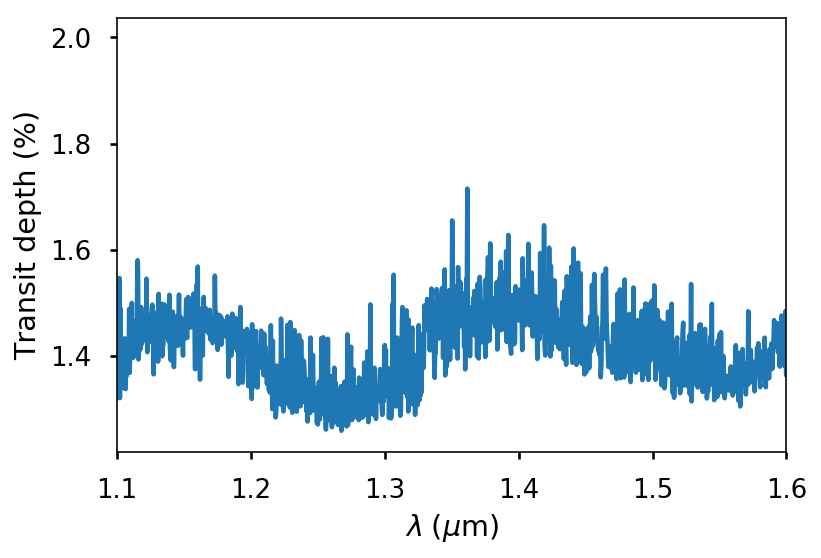

In [17]:
#plt.figure(figsize=(20,10))
plt.plot(df.wl_um, df.transit_depth*100.0)
plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.xlabel('$\lambda \;(\mu \mathrm{m})$')
plt.ylabel('Transit depth (%)')
plt.xlim(1.1, 1.6)
plt.savefig('../figures/GJ1214b_wl_depth_zoom.pdf', bbox_inches='tight')

In [18]:
df.transit_depth.std()

0.0008709565202580554

Neat!

### Now pass it through a computed model spectrum modified with Starfish

From Wikipedia and NASA Exoplanet Archive:

- $M = {0.157\pm0.019} M_{\odot}$   
- $R = 0.2064^{+0.0086}_{-0.0096} R_{\odot}$  
- L = 0.00328 L_sun  
- [Fe/H] = 0.39+/- 0.15  
- P_rot = 25 days  
- Teff = 3026±130  
- logg = 4.991  
- vsini $<$2.0
- distance = 14 pc


What is the star's solid angle?

$\Omega = \frac{R^2}{d^2}$

In [19]:
omega = (0.2064*u.Rsun)**2/(14.0*u.pc)**2

Starfish needs the log Omega.

In [20]:
np.log10(omega.to(u.dimensionless_unscaled))

<Quantity -18.9566937691683>

Following Rackham et al. 2017, with a 3.2% surface coverage of spots:

In [21]:
np.log10(0.032*omega.to(u.dimensionless_unscaled))

<Quantity -20.451543790848394>

and $\Delta T$ spot contrast = 354 K.

In [22]:
T_spot = 3026-354
T_spot

2672

We need to make "synthetic data" in this directory:
> $nubble/data/synthetic/GJ1214_synthetic.hdf5

In [23]:
#! mkdir ../data/synthetic

The keys are:
> `['fls', 'masks', 'sigmas', 'wls']`

The `masks` values should all be `1`.

We need to mimic these columns.

In [24]:
f1 = h5py.File('../data/synthetic/GJ1214_synthetic.hdf5', mode='w')

In [25]:
list(f1.keys())

[]

Let's pick a **spectral resolution** and slit sampling:

- $R$ ~ 1000   
- 3.0 pixels per slit sampling  
- $\Delta \lambda$ = 1.1 - 1.6 $\mu$m

$$R \equiv \lambda / \delta \lambda$$

$$\delta \lambda = \lambda / R$$

In [26]:
Res = 1000.0
samp = 3.0
del_lam = 1.3 #nm
bandwidth_nm = 1600.0 - 1100.0 # = 500 nm

nm_per_pixel = del_lam / samp # nm / pixel
nm_per_pixel # = 0.43

0.43333333333333335

In [27]:
N_samples = bandwidth_nm / nm_per_pixel # = number of pixels
N_samples #  ~1150

1153.8461538461538

So there will be about 1200 spectral resolution elements

In [28]:
wl_arr = np.arange(11000.0, 16000.0, 4) # use Angstroms now, for Starfish.

In [29]:
wl_arr.shape

(1250,)

First we just need a dummy file to get Starfish to even compile!

In [30]:
f1['wls'] = wl_arr
f1['fls'] = wl_arr*0.0+1.0
f1['masks'] = wl_arr.astype(int)*0+1
f1['sigmas'] = wl_arr*0.0+0.01

In [31]:
list(f1.keys())

['fls', 'masks', 'sigmas', 'wls']

In [32]:
f1.close()

In [33]:
! ls ../sf/apra_sim/

CC.npy                                  plots
PHOENIX_IGRINS_H_PCA_Teff2700-4500.hdf5 s0_o0phi.json
config.yaml                             spec_config.csv
eparams_emcee.npy                       temp_emcee_chain.npy
libraries                               user_prior.py
log.log                                 walkers_emcee.npy
output


What resolution for the spectrograph, in `km/s`?   
Use $\delta v \, \mathrm{(km/s)} = c/R$

In [34]:
299792/1000

299.792

Save a copy of the config file we used to generate the synthetic data: 

`$nubble/code/plot_specific_mix_model.py --config`

In [35]:
#! cp ../sf/apra_sim/config.yaml ../data/synthetic/config.yaml

In [36]:
df = pd.read_csv('../sf/apra_sim/spec_config.csv')

In [37]:
df.head()

,data,wl,model_composite,model_cool50,model_hot50
0,1.0,11000.0,1.435337e-14,1.552944e-15,1.489976e-14
1,1.0,11004.0,1.435789e-14,1.553890e-15,1.490536e-14
2,1.0,11008.0,1.436472e-14,1.555084e-15,1.491336e-14
3,1.0,11012.0,1.430989e-14,1.548817e-15,1.485577e-14
4,1.0,11016.0,1.418729e-14,1.533524e-15,1.472446e-14


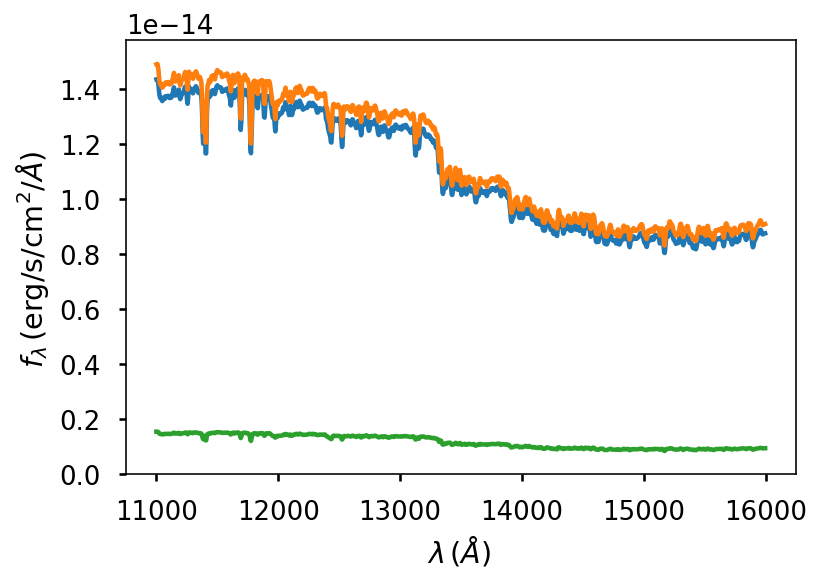

In [38]:
plt.plot(df.wl, df.model_composite)
plt.plot(df.wl, df.model_hot50) 
plt.plot(df.wl, df.model_cool50)
ymax = df.model_composite.max()*1.1
plt.ylim(0, ymax)
plt.xlabel('$\lambda \, (\AA)$ ')
plt.ylabel('$f_\lambda \, (\mathrm{erg/s/cm}^2 / \AA)$ ')

Great!  This spectrum has units of erg/s/cm$^2$/Angstrom, since we already multiplied by a factor of $\Omega$, eliminating the "per steradian". 


The spectrum can now be multiplied by a telescope collecting area (units of cm$^2$, and scaled by photon energies to get number of photons.

Let's consider a small telescope with a 3-inch aperture size $d = 7.5$ cm.

The number of photons in a given wavelength bin is:

$$\frac{dn(\lambda)}{dt} = \int \frac{f_\lambda \cdot A}{E(\lambda)} \, d\lambda$$

with:  
$E(\lambda) = h\nu = hc/\lambda$

In [39]:
d_tel = 7.5 # cm
A_tel = np.pi * d_tel**2
A_tel

176.71458676442586

The delta wavelength is 4.0!

In [40]:
df['erg_s'] = df['model_composite'] * A_tel * 4.0

In [41]:
import astropy.constants as c

In [42]:
E_erg = (c.h * c.c / (df.wl.values*u.Angstrom)).to(u.erg)
E_erg.unit

Unit("erg")

In [43]:
df['dn_dt_phot_per_s'] = df['erg_s'] / E_erg.value

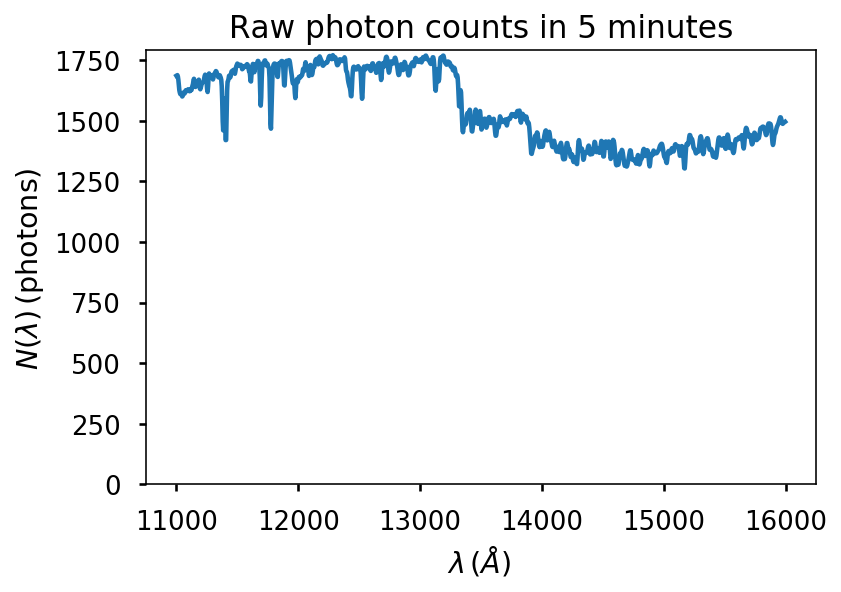

In [44]:
exp_time = 60.0 * 5.0 # 5 minute exposure
plt.plot(df.wl, df['dn_dt_phot_per_s'] * exp_time)
plt.xlabel('$\lambda \, (\AA)$ ')
plt.ylim(0)
plt.ylabel('$N(\lambda) \, (\mathrm{photons})$ ')
plt.title('Raw photon counts in 5 minutes');

We need realistic system throughput estimates.  Let's say the system efficiency of including spectrograph, telescope, and quantum efficiency is $\epsilon = 0.1$.

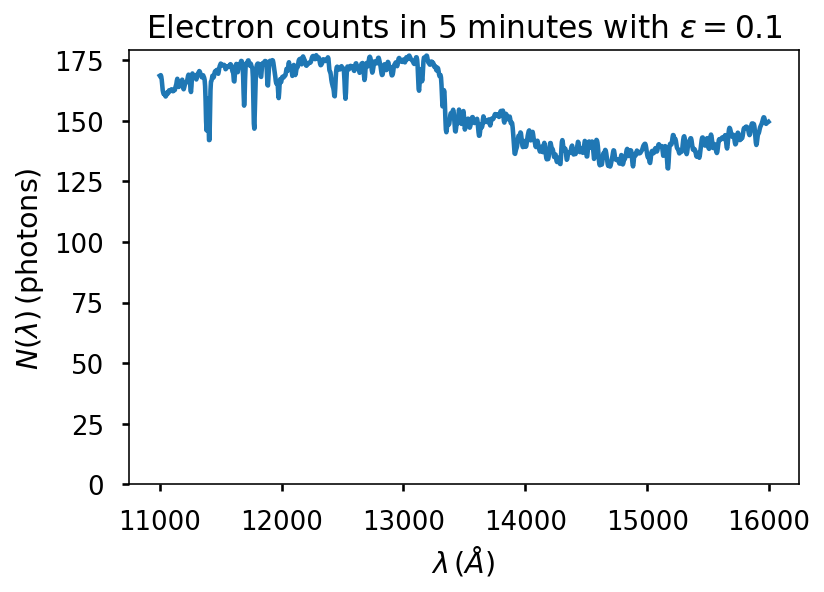

In [45]:
exp_time = 60.0 * 5.0 # 5 minute exposure
plt.plot(df.wl, df['dn_dt_phot_per_s'] * exp_time * 0.1)
plt.xlabel('$\lambda \, (\AA)$ ')
plt.ylim(0)
plt.ylabel('$N(\lambda) \, (\mathrm{photons})$ ')
plt.title('Electron counts in 5 minutes with $\epsilon = 0.1$');

In [46]:
exp_time = 60.0 * 5.0 # 5 minute exposure
sys_efficiency = 0.1
signal = df['dn_dt_phot_per_s'] * exp_time * sys_efficiency
noise = np.sqrt(signal) + 30.0 #read noise in electrons
s_to_n = signal / noise

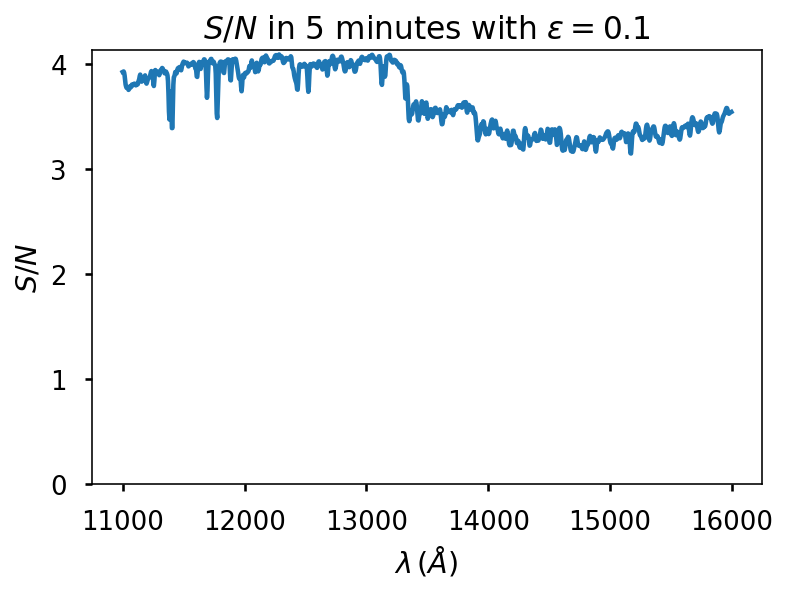

In [47]:
plt.plot(df.wl, s_to_n)
plt.xlabel('$\lambda \, (\AA)$ ')
plt.ylim(0)
plt.ylabel('$S/N$')
plt.title('$S/N$ in 5 minutes with $\epsilon = 0.1$');

Bummer!  The spectrum of GJ1214b, with a magnitude $J = 9.750$, is too low signal to noise ratio for a 3 inch space-based spectrograph with $R\sim1000$.  We have a few options:
- lower the spectral resolution
- increase the telescope size
- observe brighter targets

In [48]:
exp_time = 60.0 * 5.0 # 5 minute exposure
sys_efficiency = 0.1
# Assume a 5.0 magnitude brighter star, for a factor of 100
signal = df['dn_dt_phot_per_s'] * exp_time * sys_efficiency *100.0
noise = np.sqrt(signal) + 30.0 #read noise in electrons
s_to_n = signal / noise

If we observe a target 5 magnitudes brighter, we would have:

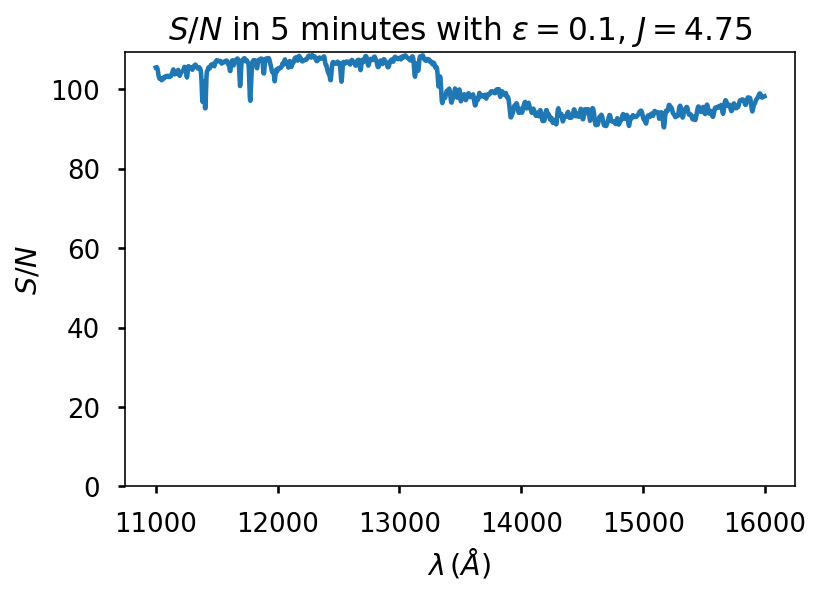

In [49]:
exp_time = 60.0 * 5.0 # 5 minute exposure
plt.plot(df.wl, s_to_n)
plt.xlabel('$\lambda \, (\AA)$ ')
plt.ylim(0)
plt.ylabel('$S/N$')
plt.title('$S/N$ in 5 minutes with $\epsilon = 0.1$, $J=4.75$');

## Figure: $S/N$ versus $J-$band

In [50]:
signal_gj1214 = df['dn_dt_phot_per_s'].median() * exp_time * sys_efficiency

In [51]:
noise = np.sqrt(signal_gj1214) + 30.0 #read noise in electrons

In [52]:
signal_gj1214 / noise

3.5777763687012012

In [53]:
J_vec = np.arange(4.0, 9.75, 0.1)

In [54]:
signal_vec = signal_gj1214 *10**(-0.4*(J_vec-9.75))
noise_vec = np.sqrt(signal_vec) + 30.0
sn_vec = signal_vec / noise_vec

In [55]:
#! mkdir ../figures

mkdir: ../figures: File exists


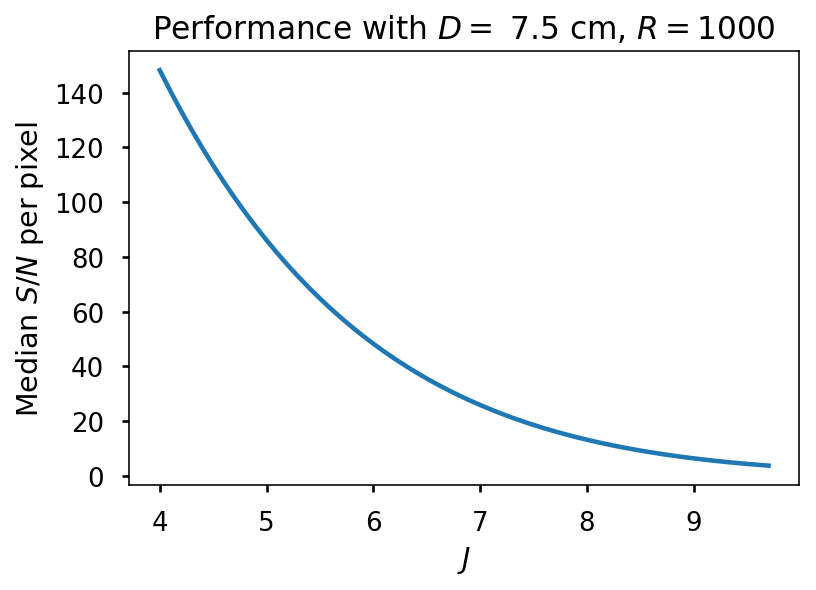

In [56]:
plt.plot(J_vec,sn_vec)
plt.xlabel('$J$')
plt.ylabel('Median $S/N$ per pixel')
plt.title('Performance with $D=$ 7.5 cm, $R=1000$')
plt.savefig('../figures/SN_vs_J.pdf', bbox_inches='tight')